In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score, mean_squared_error,mean_absolute_percentage_error,r2_score
import tensorflow as tf
import talib
from tensorflow import keras
from sklearn.pipeline import make_pipeline
from tensorflow.keras import regularizers
from keras.callbacks import EarlyStopping

In [2]:
data=yf.download('0017.hk','2018-01-01')

[*********************100%***********************]  1 of 1 completed


In [3]:
data['6day MA'] = data['Close'].rolling(window = 6).mean()
data['12day MA'] = data['Close'].rolling(window = 12).mean()
data['RSI'] = talib.RSI(data['Close'].values, timeperiod = 7)
data['%R5'] = talib.WILLR(data['High'].values, data['Low'].values, data['Close'].values, 5)
data['%R10'] = talib.WILLR(data['High'].values, data['Low'].values, data['Close'].values, 10)
data['MI6']=talib.MOM(data['Close'],timeperiod=6)
data['MI12']=talib.MOM(data['Close'],timeperiod=12)
macd, macdsignal, macdhist = talib.MACD(data['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
data['EMA12']=talib.EMA(data['Close'], timeperiod=12)
data['EMA26']=talib.EMA(data['Close'],timeperiod=26)
data['MACD']=macd
data['TR']=talib.TRANGE(data['High'],data['Low'],data['Close'])
data['OSC6']=talib.CMO(data['Close'], timeperiod=6)
data['OSC12']=talib.CMO(data['Close'], timeperiod=12)
data['Prediction']=data['Close'].shift(-1)
data.dropna(inplace=True)

In [4]:
# data=data[data.columns[list(backwardModel.k_feature_idx_)]]
data['Prediction']=data['Close'].shift(-1)
data.dropna(inplace=True)
data_val=data[-100:]
data=data[:-100]
data_val.tail()

,Open,High,Low,Close,Adj Close,Volume,6day MA,12day MA,RSI,%R5,%R10,MI6,MI12,EMA12,EMA26,MACD,TR,OSC6,OSC12,Prediction
Date,,,,,,,,,,,,,,,,,,,,
2022-03-30,32.450001,33.150002,32.150002,32.750000,32.750000,4210692,32.291667,31.270833,69.993115,-27.586298,-9.195433,1.549999,2.700001,31.671357,31.360402,0.310956,1.100002,43.594085,27.232603,31.850000
2022-03-31,32.750000,33.250000,31.850000,31.850000,31.850000,4453060,32.266667,31.500000,53.084221,-96.551647,-49.122787,-0.150000,2.750000,31.698841,31.396668,0.302173,1.400000,3.689542,7.894827,32.150002
2022-04-01,31.850000,32.200001,31.500000,32.150002,32.150002,2053614,32.266667,31.816667,57.113335,-62.857056,-42.307627,0.000000,3.800001,31.768250,31.452471,0.315780,0.700001,13.324383,12.718728,32.400002
2022-04-04,32.150002,32.400002,31.700001,32.400002,32.400002,1631328,32.258334,31.979167,60.418174,-48.571341,-36.170142,-0.049999,1.950001,31.865443,31.522658,0.342785,0.700001,21.206780,16.685529,32.299999
2022-04-06,32.450001,32.450001,31.900000,32.299999,32.299999,3053935,32.250000,32.054167,58.320835,-54.285758,-44.186090,-0.049999,0.900000,31.932298,31.580239,0.352059,0.550001,16.137067,14.416364,31.850000


In [5]:
sc = MinMaxScaler(feature_range = (-1, 1))
X=sc.fit_transform(data.drop('Prediction',1))
# X=data.drop('Prediction',1)
Y = data["Prediction"].values.reshape(-1,1)


/var/folders/8h/w0jn89bj2w5g85gj4ck7w0t00000gn/T/ipykernel_88106/543750826.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X=sc.fit_transform(data.drop('Prediction',1))


/opt/homebrew/Caskroom/miniforge/base/envs/fyp_new/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


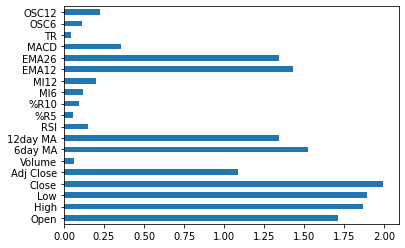

In [6]:
from sklearn.feature_selection import mutual_info_regression
importance=mutual_info_regression(X,Y)
feature_importances=pd.Series(importance,data.columns[0:len(data.columns)-1])
feature_importances.plot(kind="barh")
plt.show()

In [7]:
# X=sc.fit_transform(data.drop(['Prediction','OSC12','OSC6','MI12','MI6','Volume','%R10','%R5','RSI'],1))
# Y=np.array(data["Close"])
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1,shuffle=True)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(826, 1, 19) (826, 1) (92, 1, 19) (92, 1)


In [8]:
model_tech = keras.Sequential()
model_tech.add(keras.layers.LSTM(
  units=128,
  input_shape=(X_train.shape[1], X_train.shape[2]),
    return_sequences=True,
    kernel_regularizer=regularizers.l1(0.01)
))
model_tech.add(keras.layers.LSTM(units=64))
model_tech.add(keras.layers.Dense(units=64))
model_tech.add(keras.layers.Dense(units=1))
model_tech.compile(
  loss='mean_squared_error',
  optimizer=keras.optimizers.Adam(0.001)
)

Metal device set to: Apple M1 Pro


2022-04-10 19:44:49.732429: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-10 19:44:49.732570: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [9]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=40, min_delta=0.0001)
history_tech=model_tech.fit(
    X_train, y_train,
    epochs=500,
    batch_size=32,
    validation_split=0.1,
    verbose=1,
    shuffle=False,
    # callbacks=[es]
)
y_pred = model_tech.predict(X_test)

Epoch 1/500


2022-04-10 19:44:50.137448: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-04-10 19:44:51.413581: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-10 19:44:51.630213: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-10 19:44:51.663017: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-10 19:44:51.738428: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-10 19:44:51.799303: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


24/24 [==============================] - 3s 40ms/step - loss: 1718.3871 - val_loss: 1685.5496
Epoch 2/500
 1/24 [>.............................] - ETA: 0s - loss: 1599.2355

2022-04-10 19:44:52.629662: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-10 19:44:52.709011: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-10 19:44:52.733458: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


24/24 [==============================] - 0s 12ms/step - loss: 1448.3831 - val_loss: 1073.8762
Epoch 3/500
24/24 [==============================] - 0s 12ms/step - loss: 612.2974 - val_loss: 355.3289
Epoch 4/500
24/24 [==============================] - 0s 12ms/step - loss: 152.2488 - val_loss: 62.6391
Epoch 5/500
24/24 [==============================] - 0s 12ms/step - loss: 52.5849 - val_loss: 43.1996
Epoch 6/500
24/24 [==============================] - 0s 13ms/step - loss: 41.7894 - val_loss: 32.0730
Epoch 7/500
24/24 [==============================] - 0s 12ms/step - loss: 34.4217 - val_loss: 25.8815
Epoch 8/500
24/24 [==============================] - 0s 13ms/step - loss: 29.7045 - val_loss: 22.1634
Epoch 9/500
24/24 [==============================] - 0s 12ms/step - loss: 26.4219 - val_loss: 19.6530
Epoch 10/500
24/24 [==============================] - 0s 12ms/step - loss: 23.9090 - val_loss: 17.8654
Epoch 11/500
24/24 [==============================] - 0s 12ms/step - loss: 21.8593 - v

Epoch 83/500
24/24 [==============================] - 0s 11ms/step - loss: 1.8773 - val_loss: 2.0300
Epoch 84/500
24/24 [==============================] - 0s 11ms/step - loss: 1.8510 - val_loss: 2.0043
Epoch 85/500
24/24 [==============================] - 0s 11ms/step - loss: 1.8254 - val_loss: 1.9796
Epoch 86/500
24/24 [==============================] - 0s 11ms/step - loss: 1.8006 - val_loss: 1.9555
Epoch 87/500
24/24 [==============================] - 0s 11ms/step - loss: 1.7764 - val_loss: 1.9325
Epoch 88/500
24/24 [==============================] - 0s 11ms/step - loss: 1.7529 - val_loss: 1.9098
Epoch 89/500
24/24 [==============================] - 0s 11ms/step - loss: 1.7301 - val_loss: 1.8884
Epoch 90/500
24/24 [==============================] - 0s 11ms/step - loss: 1.7079 - val_loss: 1.8676
Epoch 91/500
24/24 [==============================] - 0s 12ms/step - loss: 1.6862 - val_loss: 1.8471
Epoch 92/500
24/24 [==============================] - 0s 11ms/step - loss: 1.6652 - val_los

24/24 [==============================] - 0s 11ms/step - loss: 0.8806 - val_loss: 0.9384
Epoch 164/500
24/24 [==============================] - 0s 11ms/step - loss: 0.8747 - val_loss: 0.9307
Epoch 165/500
24/24 [==============================] - 0s 11ms/step - loss: 0.8686 - val_loss: 0.9226
Epoch 166/500
24/24 [==============================] - 0s 11ms/step - loss: 0.8630 - val_loss: 0.9144
Epoch 167/500
24/24 [==============================] - 0s 11ms/step - loss: 0.8570 - val_loss: 0.9072
Epoch 168/500
24/24 [==============================] - 0s 11ms/step - loss: 0.8512 - val_loss: 0.8996
Epoch 169/500
24/24 [==============================] - 0s 11ms/step - loss: 0.8452 - val_loss: 0.8921
Epoch 170/500
24/24 [==============================] - 0s 12ms/step - loss: 0.8394 - val_loss: 0.8857
Epoch 171/500
24/24 [==============================] - 0s 11ms/step - loss: 0.8335 - val_loss: 0.8789
Epoch 172/500
24/24 [==============================] - 0s 11ms/step - loss: 0.8277 - val_loss: 0

24/24 [==============================] - 0s 12ms/step - loss: 0.6389 - val_loss: 0.7602
Epoch 244/500
24/24 [==============================] - 0s 13ms/step - loss: 0.6384 - val_loss: 0.7609
Epoch 245/500
24/24 [==============================] - 0s 11ms/step - loss: 0.6379 - val_loss: 0.7617
Epoch 246/500
24/24 [==============================] - 0s 11ms/step - loss: 0.6375 - val_loss: 0.7632
Epoch 247/500
24/24 [==============================] - 0s 11ms/step - loss: 0.6371 - val_loss: 0.7635
Epoch 248/500
24/24 [==============================] - 0s 12ms/step - loss: 0.6366 - val_loss: 0.7641
Epoch 249/500
24/24 [==============================] - 0s 11ms/step - loss: 0.6361 - val_loss: 0.7656
Epoch 250/500
24/24 [==============================] - 0s 12ms/step - loss: 0.6357 - val_loss: 0.7663
Epoch 251/500
24/24 [==============================] - 0s 11ms/step - loss: 0.6354 - val_loss: 0.7662
Epoch 252/500
24/24 [==============================] - 0s 11ms/step - loss: 0.6348 - val_loss: 0

24/24 [==============================] - 0s 11ms/step - loss: 0.6040 - val_loss: 0.7212
Epoch 324/500
24/24 [==============================] - 0s 11ms/step - loss: 0.6033 - val_loss: 0.7207
Epoch 325/500
24/24 [==============================] - 0s 11ms/step - loss: 0.6032 - val_loss: 0.7191
Epoch 326/500
24/24 [==============================] - 0s 11ms/step - loss: 0.6026 - val_loss: 0.7187
Epoch 327/500
24/24 [==============================] - 0s 11ms/step - loss: 0.6022 - val_loss: 0.7176
Epoch 328/500
24/24 [==============================] - 0s 11ms/step - loss: 0.6018 - val_loss: 0.7179
Epoch 329/500
24/24 [==============================] - 0s 12ms/step - loss: 0.6017 - val_loss: 0.7165
Epoch 330/500
24/24 [==============================] - 0s 12ms/step - loss: 0.6012 - val_loss: 0.7160
Epoch 331/500
24/24 [==============================] - 0s 12ms/step - loss: 0.6010 - val_loss: 0.7162
Epoch 332/500
24/24 [==============================] - 0s 12ms/step - loss: 0.6007 - val_loss: 0

24/24 [==============================] - 0s 12ms/step - loss: 0.5809 - val_loss: 0.6787
Epoch 404/500
24/24 [==============================] - 0s 11ms/step - loss: 0.5807 - val_loss: 0.6776
Epoch 405/500
24/24 [==============================] - 0s 14ms/step - loss: 0.5804 - val_loss: 0.6780
Epoch 406/500
24/24 [==============================] - 0s 12ms/step - loss: 0.5803 - val_loss: 0.6772
Epoch 407/500
24/24 [==============================] - 0s 12ms/step - loss: 0.5801 - val_loss: 0.6769
Epoch 408/500
24/24 [==============================] - 0s 12ms/step - loss: 0.5799 - val_loss: 0.6763
Epoch 409/500
24/24 [==============================] - 0s 12ms/step - loss: 0.5797 - val_loss: 0.6758
Epoch 410/500
24/24 [==============================] - 0s 12ms/step - loss: 0.5794 - val_loss: 0.6749
Epoch 411/500
24/24 [==============================] - 0s 11ms/step - loss: 0.5791 - val_loss: 0.6754
Epoch 412/500
24/24 [==============================] - 0s 11ms/step - loss: 0.5789 - val_loss: 0

24/24 [==============================] - 0s 11ms/step - loss: 0.5685 - val_loss: 0.6609
Epoch 484/500
24/24 [==============================] - 0s 11ms/step - loss: 0.5683 - val_loss: 0.6608
Epoch 485/500
24/24 [==============================] - 0s 12ms/step - loss: 0.5682 - val_loss: 0.6607
Epoch 486/500
24/24 [==============================] - 0s 11ms/step - loss: 0.5680 - val_loss: 0.6609
Epoch 487/500
24/24 [==============================] - 0s 11ms/step - loss: 0.5680 - val_loss: 0.6607
Epoch 488/500
24/24 [==============================] - 0s 12ms/step - loss: 0.5678 - val_loss: 0.6601
Epoch 489/500
24/24 [==============================] - 0s 12ms/step - loss: 0.5677 - val_loss: 0.6597
Epoch 490/500
24/24 [==============================] - 0s 12ms/step - loss: 0.5676 - val_loss: 0.6602
Epoch 491/500
24/24 [==============================] - 0s 11ms/step - loss: 0.5675 - val_loss: 0.6598
Epoch 492/500
24/24 [==============================] - 0s 12ms/step - loss: 0.5673 - val_loss: 0

2022-04-10 19:47:14.396485: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-10 19:47:14.470592: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-10 19:47:14.512940: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


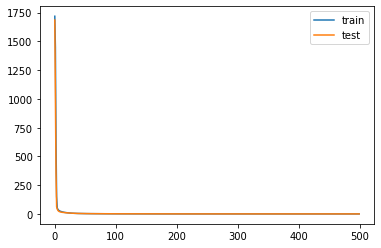

In [10]:
plt.plot(history_tech.history['loss'], label='train')
plt.plot(history_tech.history['val_loss'], label='test')
plt.legend()

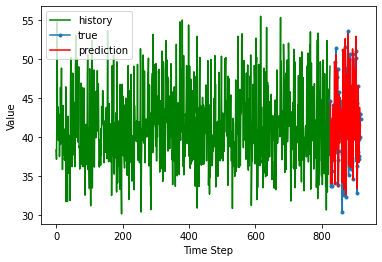

In [11]:
plt.plot(np.arange(0, len(y_train)), y_train, 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test, marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show()

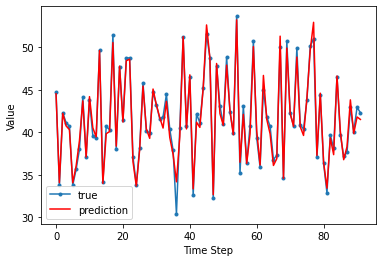

In [12]:
# y_test = sc.inverse_transform(y_test)
# y_pred = sc.inverse_transform(y_pred)
plt.plot(y_test, marker='.', label="true")
plt.plot(y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [13]:
r2_score(y_test,y_pred)

0.9789981793035142

In [14]:
mean_absolute_percentage_error(y_test,y_pred)

0.013233563830726602

In [15]:
mean_squared_error(y_test,y_pred,squared=False)

0.7508415831299287

In [16]:
x_val=data_val.drop(['Prediction'],1)
y_val=data_val['Prediction']
x_val=sc.transform(x_val).reshape(x_val.shape[0],1,x_val.shape[1])
y_val_pred=model_tech.predict(x_val)

/var/folders/8h/w0jn89bj2w5g85gj4ck7w0t00000gn/T/ipykernel_88106/2648236666.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_val=data_val.drop(['Prediction'],1)


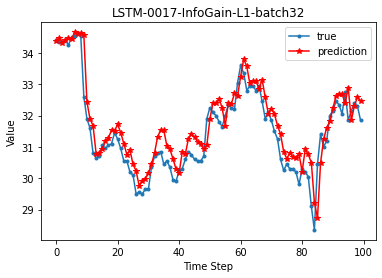

In [17]:
plt.plot(y_val.values, marker='.', label="true")
plt.plot(y_val_pred, 'r', marker='*',label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.title('LSTM-0017-InfoGain-L1-batch32')
plt.legend()
plt.show()

In [18]:
r2_score(y_val,y_val_pred)

0.8365454238655835

In [19]:
mean_absolute_percentage_error(y_val,y_val_pred)

0.014148644539954722

In [20]:
mean_squared_error(y_val.values,y_val_pred,squared=False)

0.5580230916084525